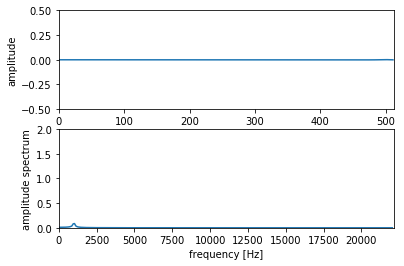

In [2]:
#coding:utf-8
import wave
import struct
import numpy as np
from pylab import *

def sinc(x):
    if x == 0.0: return 1.0
    else: return np.sin(x) / x

def fft(x, fs):
    start = 0
    N = 512  # FFTのサンプル数

    # 最低、N点ないとFFTできないので0.0を追加
    for i in range(N): x.append(0.0)

    X = np.fft.fft(x[start:start+N])
    freqList = np.fft.fftfreq(N, d=1.0/fs)

    amplitudeSpectrum = [np.sqrt(c.real ** 2 + c.imag ** 2) for c in X]

    # 波形を描画
    subplot(211)
    plot(range(start, start+N), x[start:start+N])
    axis([start, start+N, -0.5, 0.5])
    xlabel("time [sample]")
    ylabel("amplitude")

    # 振幅スペクトルを描画
    subplot(212)
    n = len(freqList) // 2  # FFTの結果は半分まで見ればOK
    plot(freqList[:n], amplitudeSpectrum[:n], linestyle='-')
    axis([0, fs/2, 0, 2])
    xlabel("frequency [Hz]")
    ylabel("amplitude spectrum")

    show()

def createLPF(fe, delta):
    """ローパスフィルタを設計、fe:エッジ周波数、delta:遷移帯域幅"""
    # 遷移帯域幅を満たすフィルタ係数の数を計算
    # N+1が奇数になるように調整が必要
    N = round(3.1 / delta) - 1
    if (N + 1) % 2 == 0: N += 1
    N = int(N)

    # フィルタ係数を求める
    b = []
    for i in range(-N//2,N//2 + 1):
        b.append(2.0 * fe * sinc(2.0 * math.pi * fe * i))

    # ハニング窓関数をかける（窓関数法）
    hanningWindow = np.hanning(N + 1)
    for i in range(len(b)):
        b[i] *= hanningWindow[i]

    return b

def fir(x, b):
    """FIRフィルタをかける、x:入力信号、b:フィルタ係数"""
    y = [0.0] * len(x)  # フィルタの出力信号
    N = len(b) - 1      # フィルタ係数の数
    for n in range(len(x)):
        for i in range(N+1):
            if n - i >= 0:
                y[n] += b[i] * x[n - i]
    return y

def save(data, fs, bit, filename):
    """波形データをWAVEファイルへ出力"""
    wf = wave.open(filename, "w")
    wf.setnchannels(1)
    wf.setsampwidth(bit // 8)
    wf.setframerate(fs)
    wf.writeframes(data)
    wf.close()

if __name__ == '__main__':
    wf = wave.open("yukkurisan.wav", "r")
    fs = wf.getnframes()

    x = wf.readframes(wf.getnframes())
    x = frombuffer(x, dtype="int16") / 32768.0

    # LPFを設計
    fe = 1000.0 / fs        # 正規化したエッジ周波数
    delta = 100.0 / fs      # 正規化した遷移帯域幅
    b = createLPF(fe, delta)

    # フィルタをかける
    y = fir(x, b)
    fft(b, fs)

    # 正規化前のバイナリデータに戻す
    y = [int(v * 32767.0) for v in y]
    y = struct.pack("h" * len(y), *y)

    # 音声を保存
    save(y, fs, 16, "yukkurisan_low_pass.wav")